## Algorithmic Trading - Optimizing strategy on back-testing using python

In this article, I will describe code snippets on how to back-test trading strategies in python. This is a follow-up post to my previous article on backtesting a strategy in python, which I highly you go through to understand this article. The motivation behind this article is to show how a single strategy can be applied to various stock symbols with varying time periods (start and end dates) and code that encapsulates plotting and optimization techniques.

This article covers two topics in particular.
1. Organizing code in an object oriented fashion
2. Optimizing strategy parameters to maximize returns

For simplicity, I will be basing the code snippets on a technical indicator-based strategy (Bollinger Bands)

#### Here are the steps...
1. Download all necessary libraries
2. Create the Financial data class
3. Strategy class (Bollinger band based strategy)
4. Create the class object and back-test
5. Create a tear sheet with pyfolio

#### Step 1. Download all necessary libraries
In this step, all necessary libraries are imported

In [26]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import pyfolio as pf

#### Step 2. Financial Data Class
In this code snippet, a financial data class is created.
The class object takes in a symbol, end date, and the number of days for which daily data needs to be downloaded.

This will be the base class that can be inherited by any other strategy class to encapsulate all the basic functionality such as downloading data, plotting data, preparing data, and creating tear sheets.

In [27]:
class FinancialData:
    # initialize function 
    def __init__(self, symbol='TSLA', end=dt.datetime.today(), days=168):
        self.symbol = symbol
        self.start = end - pd.Timedelta(days=days)
        self.end = end
        self.retrieve_data(self.symbol, self.start, self.end)
        self.prepare_data()
    
    # function call to retrieve daily data
    def retrieve_data(self, symbol, start, end):
        self.data = yf.download(symbol, start=start, end=end)
    
    # preparing data - adding daily returns and buy/hold returns column
    def prepare_data(self):
        self.data['daily_returns'] = np.log(self.data['Adj Close'] \
                                    / self.data['Adj Close'].shift(1))
        self.data['bnh_returns'] = self.data['daily_returns'].cumsum()
        self.data.dropna(inplace=True)

    # function to plot a list of attributes in the pandas data frame
    def plot_data(self, attribute_list):
        self.data[attribute_list].plot()
        plt.show()

    # plotting strategy returns
    def plot_strategy_returns(self):
        self.plot_data(['bnh_returns', 'strategy_returns'])

    # function to create a simple tear sheet using pyfolio
    def create_simple_tear_sheet(self):
        pf.display(\
        pf.create_simple_tear_sheet(self.data['strategy_returns'].diff()))

#### Step 3. Strategy class (Bollinger band based strategy)
In this step, a strategy class is created which contains the following functionality
+ Preparing indicators - please refer to this article on how to create an example strategy in python
+ Backtesting the strategy, which involves creating signals, positions, and strategy returns
+ Optimizer - this function iterates through one or more parameters with a range of values and selects the parameters with the highest returns. This could be further modified to sort return values in conjunction with a high Sharpe ratio as well.
+ Plot the returns of the optimized strategy.

In [28]:
class BollingerBandBacktester(FinancialData):
    def prepare_indicators(self, window):
        self.data['moving_avg'] = \
        self.data['Adj Close'].rolling(window=window).mean()
        self.data['moving_std'] = \
        self.data['Adj Close'].rolling(window=window).std()

    def backtest_strategy(self, window, start=None):
        self.prepare_indicators(window)
        self.data['upper_band'] = \
        self.data['moving_avg'] + 2 * self.data['moving_std']
        self.data['lower_band'] = \
        self.data['moving_avg'] - 2 * self.data['moving_std']

        if start is None:
            start = window

        # BUY condition
        self.data['signal'] = \
        np.where((self.data['Adj Close'] < self.data['lower_band']) &
                 (self.data['Adj Close'].shift(1) >= self.data['lower_band']), 1, 0)

        # SELL condition
        self.data['signal'] = \
        np.where((self.data['Adj Close'] > self.data['upper_band']) &
                 (self.data['Adj Close'].shift(1) <= self.data['upper_band']), -1,
                  self.data['signal'])

        self.data['position'] = self.data['signal'].replace(to_replace=0, method='ffill')
        self.data['position'] = self.data['position'].shift()

        self.data['strategy_returns'] = self.data['position'] * self.data['daily_returns']

        performance = self.data[['daily_returns', 'strategy_returns']].iloc[start:].sum()

        self.data['strategy_returns'] = self.data['strategy_returns'].cumsum()
        return performance

    def optimize_bollinger_band_parameters(self, windows):
        start = max(windows)
        self.results = pd.DataFrame()
        for window in windows:
            perf = self.backtest_strategy(window=window, start=start)
            self.result = pd.DataFrame({'Window': window,
                                        'bnh returns': perf['daily_returns'],
                                        'strategy returns': perf['strategy_returns']}, 
                                         index=[0, ])
            self.results = self.results.append(self.result, ignore_index=True)
        self.results.sort_values(by='strategy returns', inplace=True, ascending=False)
        self.results = self.results.reset_index()
        self.results = self.results.drop("index", axis=1)
        print(self.results.head())

    def plot_optimized_bollinger_strategy_returns(self):
        if (len(self.results)) > 0:
            window = self.results.loc[0, 'Window']
            print("Window:", window)
            self.backtest_strategy(window=window)
            self.plot_strategy_returns()


#### Step 4. Create the class object and back-test 
In this step, the object for the specific strategy class is created. The optimizer function in the strategy class reuses the strategy function to iterate through various window values for moving averages needed in the Bollinger band strategy and plots the strategy parameter with the highest return.

[*********************100%***********************]  1 of 1 completed
   Window  bnh returns  strategy returns
0      41     0.041484          0.216779
1      40     0.041484          0.205460
2      39     0.041484          0.205460
3      27     0.041484          0.183269
4      28     0.041484          0.183269
Window: 41


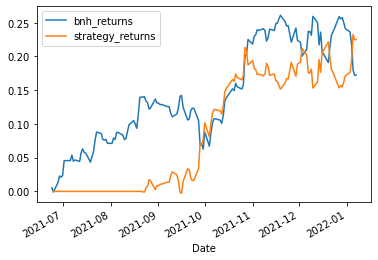

In [29]:
_symbol = "MSFT"
_end_date = dt.datetime.today()
_days = 200
Bollinger = BollingerBandBacktester(symbol=_symbol, end = _end_date, days = _days)
Bollinger.optimize_bollinger_band_parameters(range(1, 50, 1))
Bollinger.plot_optimized_bollinger_strategy_returns()

#### 5. Create a tear sheet with pyfolio

Start date,2021-06-24
End date,2022-01-07
Total months,6
,Backtest
Annual return,48.3%
Cumulative returns,24.1%
Annual volatility,18.5%
Sharpe ratio,2.25
Calmar ratio,7.27
Stability,0.83
Max drawdown,-6.6%


None

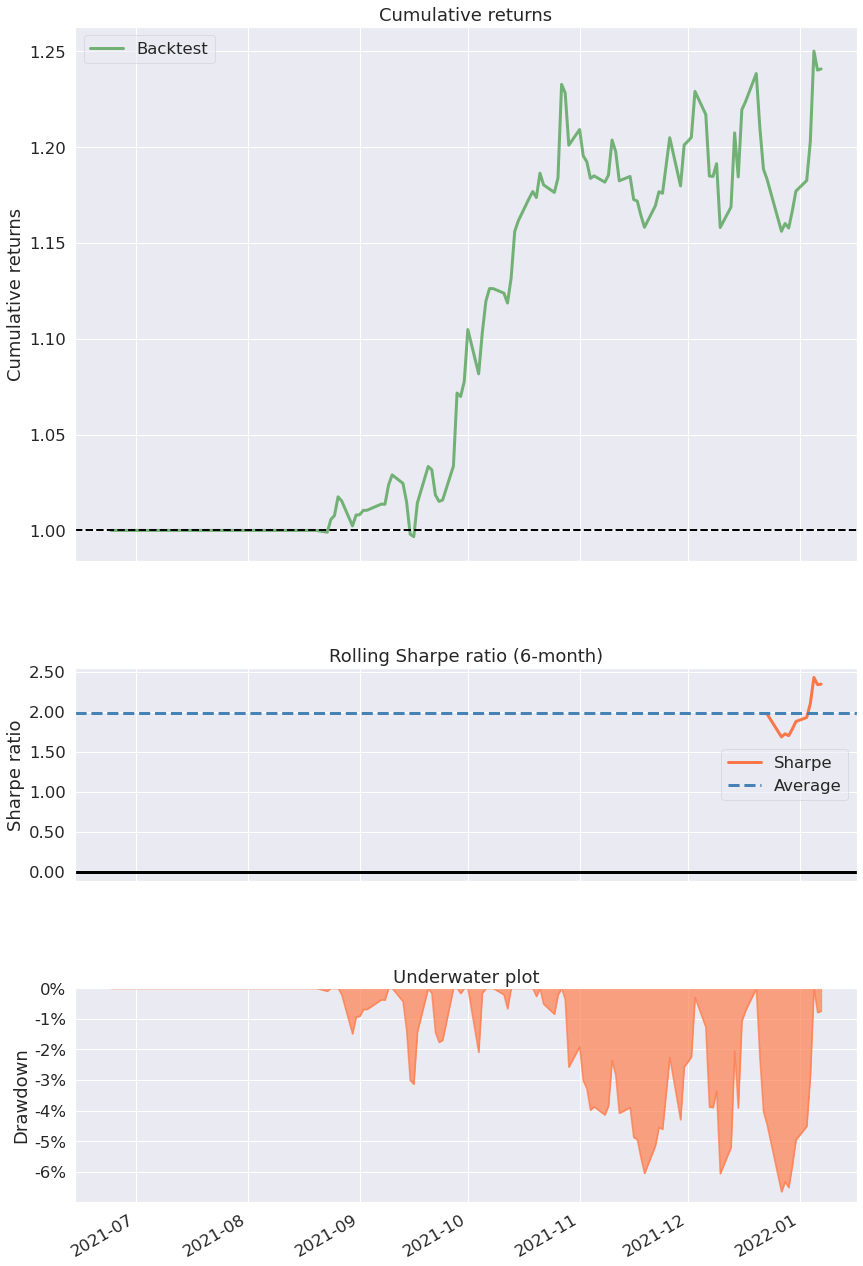

In [30]:
Bollinger.create_simple_tear_sheet()

#### Conclusion
The above code snippets can be found at: https://github.com/karthikramx/Algorithmic-Trading-optimize-back-test